In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy
from decimal import *
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import threading
import numpy as np
import datetime
import scipy.stats as ss
import itertools

In [2]:
def setupStake(
        # Number of nodes in the network. This number can be changed to test with small and large network size
        numNodes=10,
        # the minimum number of channels a node can open
        minChannelsPerNode=2,
        # the maximum number of channels a node can open 
        maxChannelsPerNode=10,
        minFundsPerNode=10,
        maxFundsPerNode=100,
        tokensPerTicket=0.1
    ):

    stake = [[0 for i in range(numNodes)] for j in range(numNodes)]
    for x in range(numNodes):
        # each node is given a random funding amount
        myFunds = numpy.random.rand() * (maxFundsPerNode - minFundsPerNode) + minFundsPerNode

        # get random number of channels per node
        myChannels = int(numpy.random.rand() * (maxChannelsPerNode - minChannelsPerNode + 1) + minChannelsPerNode)

        # This value represents the amount each node stakes in their channel
        # It is computed as the number of funds a node has divided by number of channels they open
        stakePerChannel = myFunds / myChannels
        stakePerChannel = int(stakePerChannel / tokensPerTicket) * tokensPerTicket

        # fund channels by writing into stake matrix
        for c in range(myChannels):
            # TODO: this does not prevent a node from opening a channel to the same counterparty multiple times
            counterparty = int(numpy.random.rand() * (numNodes - 1))

            # cannot open channel to self - keep diagonal of matrix at 0
            if counterparty >= x:
                counterparty = counterparty + 1
            stake[x][counterparty] = stakePerChannel
            stake = [[Decimal(i) for i in j] for j in stake]

    return stake

In [3]:
initial_stake = setupStake()

In [4]:
def calcImportance(stake):

    # get total stake per node
    stakePerNode = [Decimal(sum(e)) for e in stake]

    totalStake = sum(stakePerNode)

    n = len(stake)
    weight = [0] * n
    importance = [0] * n
    for x in range(n):
        for y in range(n):
            # weight of a node is 0 if its stake is equal to 0
            #weight(channel) = sqrt(balance(channel) / stake(channel.source) * stake(channel.destination))
            weight[y] += 0 if stakePerNode[y]==0 else numpy.sqrt(stake[y][x]/stakePerNode[y] * stakePerNode[x])

    #print("Weighted downstream stake per node p(n) = ", weight)
    importanceList = numpy.array(weight) * numpy.array(stakePerNode)
    return importanceList;

In [5]:
initial_importance = calcImportance(initial_stake)
initial_importance

array([Decimal('258.1191164371974744867325457'),
       Decimal('648.2499444934105603585537915'),
       Decimal('153.9745433505162307335901280'),
       Decimal('100.1787964567964375349704388'),
       Decimal('356.5616780993049853190248154'),
       Decimal('693.6389653313268746838693173'),
       Decimal('339.1237088818092482202570703'),
       Decimal('752.4076306095077357252088235'),
       Decimal('1301.307964976597074825540446'),
       Decimal('349.9930899336560073975909380')], dtype=object)

In [6]:
#MODEL1 = based on stake

In [7]:
numNodes=10
def recalculating_stakes_with_stakes(stake, importance):
    #calculating sum of the original stake
    sum_stake = sum([sum(stake[li]) for li in range(numNodes)])
    #creating an empy stake matrix with the original shape
    stake_mod = [[0 for i in range(numNodes)] for j in range(numNodes)]
    #populating it with recalculation
    for p in range(numNodes):
        for r in range(numNodes):
            if p == r:
                stake_mod[p][r] = 0
            else:
                stake_mod[p][r] = sum(stake[r])/(sum_stake-sum(stake[p]))*sum(stake[p])
    
    return stake_mod

In [8]:
based_on_stake = recalculating_stakes_with_stakes(initial_stake, initial_importance)
based_on_stake

[[0,
  Decimal('3.093530787217459194326571455'),
  Decimal('1.833203429462197911859259939'),
  Decimal('0.4583008573655495021941561302'),
  Decimal('1.484021823850350782854986219'),
  Decimal('2.356975837879968702283035101'),
  Decimal('1.734996102883866040088184255'),
  Decimal('3.982852689010132587245407253'),
  Decimal('4.844894777864380223318719720'),
  Decimal('1.211223694466095055829679930')],
 [Decimal('3.409793814432989852405473429'),
  0,
  Decimal('5.455670103092783994592017037'),
  Decimal('1.363917525773196070755272869'),
  Decimal('4.416494845360825413173608495'),
  Decimal('7.014432989690722155148704290'),
  Decimal('5.163402061855671040158066988'),
  Decimal('11.85309278350515635493532444'),
  Decimal('14.41855670103092921097292344'),
  Decimal('3.604639175257732302743230859')],
 [Decimal('1.895245769540692928162749975'),
  Decimal('5.117163577759871483176473802'),
  0,
  Decimal('0.7580983078162772434072310984'),
  Decimal('2.454794520547945382506631211'),
  Decimal('3.

In [9]:
based_on_stake_importance_score = calcImportance(based_on_stake)
based_on_stake_importance_score

array([Decimal('411.9962378469007487187935111'),
       Decimal('1059.546878623121765372339245'),
       Decimal('648.3145903031953722086180750'),
       Decimal('167.4741771139658633180730229'),
       Decimal('529.3178704710432106199648840'),
       Decimal('822.7303616617051078453674107'),
       Decimal('615.0649429125351529467076205'),
       Decimal('1331.924960348742943851944211'),
       Decimal('1581.288406332001296159113727'),
       Decimal('434.8594117643080655892451161')], dtype=object)

In [10]:
#iterating through the recalculations
def iterating_recalculating_stakes(stake, importance):   
    
    iterated_stakes = []
    iterated_importance = []
    difference_between_stake_matrix = []
    added_list =[]
    incoming_stake = []
    incoming_stake_sum = []
    
    for _ in range(100):
        #recalculating the stake matrix
        a = recalculating_stakes_with_stakes(stake, importance)
        iterated_stakes.append(a)
        
        #recalculating the importance
        b = calcImportance(a)
        iterated_importance.append(importance)
        
        #the following session calculates the difference between each iteration
        #dataframe of the initial stake matrix
        df_stake = pd.DataFrame(stake)
        
        #dataframe of the recalculated stake
        df_a = pd.DataFrame(a)
        
        #difference between the frames
        c = df_stake - df_a
        difference_between_stake_matrix.append(c)
        
        #reasigning stake and importance
        stake = a
        importance = b 
    
    input_stake_matrix = difference_between_stake_matrix
    
    #calculating the sum of the change
    for k in range(len(input_stake_matrix)):
        #absolute sum of the difference
        sum_of_difference_by_column = (abs(input_stake_matrix[k])).sum()
        total_sum_of_difference = sum(sum_of_difference_by_column)
        
        #craeting a list of the difference
        added_list.append(total_sum_of_difference)
        incoming_stake.append(sum_of_difference_by_column)
        
    #creating dataframe form the list and transpose
    input_incoming_stake = (pd.DataFrame(incoming_stake)).T
    input_incoming_stake["sum"] = input_incoming_stake.sum(axis=1)
    
    #plotting
    df = pd.DataFrame(added_list)
    plt.scatter(df.index,df[0])
    plt.xlabel('Number of iterations')
    plt.ylabel('Absolute change of the incoming stakes')
    plt.show()
    
    return input_incoming_stake

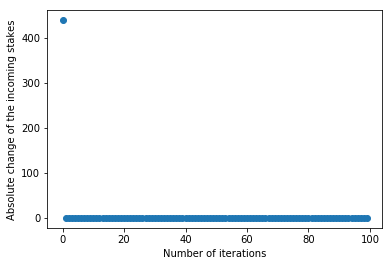

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,sum
0,77.489990,4.100000e-27,4.000000e-27,7.100000e-27,1.030000e-26,1.730000e-26,4.000000e-27,4.000000e-27,5.100000e-27,3.100000e-27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.489990
1,40.202057,5.000000e-27,7.000000e-27,2.200000e-26,2.000000e-26,1.900000e-26,1.300000e-26,1.000000e-26,4.000000e-27,5.000000e-27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.202057
2,43.176298,1.200000e-26,4.000000e-27,5.300000e-27,1.120000e-26,9.200000e-27,5.000000e-27,6.000000e-27,1.110000e-26,5.100000e-27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.176298
3,33.317857,4.300000e-27,4.000000e-28,5.100000e-27,3.000000e-27,3.000000e-27,4.100000e-27,1.000000e-27,1.300000e-27,1.500000e-27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.317857
4,43.036454,9.300000e-27,1.030000e-26,6.000000e-27,1.000000e-28,1.020000e-26,5.100000e-27,5.000000e-27,5.200000e-27,4.000000e-27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.036454
5,36.227386,9.000000e-27,3.000000e-27,2.100000e-27,2.120000e-26,2.660000e-26,2.010000e-26,5.000000e-27,7.200000e-27,2.270000e-26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.227386
6,33.750381,1.210000e-26,1.620000e-26,7.200000e-27,1.330000e-26,1.120000e-26,8.200000e-27,6.000000e-27,1.210000e-26,4.100000e-27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.750381
7,40.014905,1.000000e-26,1.400000e-26,2.300000e-26,2.200000e-26,1.600000e-26,2.000000e-27,3.900000e-26,2.200000e-26,4.000000e-27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.014905
8,51.474328,2.000000e-26,8.000000e-27,5.100000e-26,1.300000e-26,2.100000e-26,1.200000e-26,2.900000e-26,2.900000e-26,9.000000e-27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.474328
9,40.466822,1.030000e-26,3.000000e-27,6.200000e-27,1.120000e-26,8.100000e-27,4.100000e-27,4.000000e-27,6.200000e-27,3.000000e-27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.466822


In [11]:
based_on_stake_iteration = iterating_recalculating_stakes(initial_stake, initial_importance)
based_on_stake_iteration

In [12]:
#MODEL2_based on importance

In [13]:
numNodes=10
def recalculating_stakes_with_importance(stake, importance):
    #calculating sum of the original stake
    sum_stake = sum([sum(stake[li]) for li in range(numNodes)])
    
    #creating an empy stake matrix with the original shape
    stake_mod = [[0 for i in range(numNodes)] for j in range(numNodes)]
    stake_mod_i = [[0 for i in range(numNodes)] for j in range(numNodes)]
    
    #populating it with recalculation
    for p in range(numNodes):
        for r in range(numNodes):
            if p == r:
                stake_mod[p][r] = 0
            else:
                stake_mod[p][r] = importance[r]/(sum(importance)-importance[p])*sum(stake[p])
                
    return stake_mod

In [14]:
based_on_importance = recalculating_stakes_with_importance(initial_stake, initial_importance)
based_on_importance

[[0,
  Decimal('2.899251081351633836243288857'),
  Decimal('0.6886400301329234516236843340'),
  Decimal('0.4480424355189815900002901252'),
  Decimal('1.594696366084257042636770991'),
  Decimal('3.102250200539616066851757298'),
  Decimal('1.516706307558436481317735894'),
  Decimal('3.365088813646647404957470116'),
  Decimal('5.820005935485650779832493458'),
  Decimal('1.565318829681853346536508929')],
 [Decimal('3.399376402470064823963299278'),
  0,
  Decimal('2.027813501268514976643379888'),
  Decimal('1.319334427467494778275843884'),
  Decimal('4.695844969897127343028739839'),
  Decimal('9.135084464597453952756910779'),
  Decimal('4.466190452699144938516635480'),
  Decimal('9.909055864735565092674088774'),
  Decimal('17.13796192063168234449156391'),
  Decimal('4.609337996232958144534160022')],
 [Decimal('1.806991589813178593026166684'),
  Decimal('4.538145852833258659436080127'),
  0,
  Decimal('0.7013128092706827193159529471'),
  Decimal('2.496149694251268072193475529'),
  Decimal('4

In [15]:
based_on_importance_importance = calcImportance(based_on_importance)
based_on_importance_importance

array([Decimal('407.7615231145304546499371411'),
       Decimal('1047.707885305341037255726434'),
       Decimal('646.1241982312543280415408887'),
       Decimal('165.8082576686950706252727841'),
       Decimal('523.8014520702978785838556572'),
       Decimal('814.8149323970916253689541239'),
       Decimal('608.7154038543210194140020783'),
       Decimal('1317.491038305069589855399613'),
       Decimal('1563.738072089867727112510152'),
       Decimal('430.5905778893723192025492393')], dtype=object)

In [16]:
def iterating_recalculating_stakes_with_importance(stake, importance):
    iterated_stakes = []
    iterated_importance = []
    difference_between_stake_matrix = []
    added_list =[]
    incoming_stake = []
    incoming_stake_sum = []
    
    for _ in range(100):  
         #recalculating the stake matrix
        a = recalculating_stakes_with_importance(stake, importance)
        iterated_stakes.append(a)
        
        #recalculating the importance
        b = calcImportance(a)
        iterated_importance.append(importance)
        
        #the following session calculates the difference between each iteration
        #dataframe of the initial stake matrix
        df_stake = pd.DataFrame(stake)
        
        #dataframe of the recalculated stake
        df_a = pd.DataFrame(a)
        
        #difference between the frames
        c = df_stake - df_a
        difference_between_stake_matrix.append(c)
        
        #reasigning stake and importance
        stake = a
        importance = b 
    
    input_stake_matrix = difference_between_stake_matrix
    
    #calculating the sum of the change
    for k in range(len(input_stake_matrix)):
        #absolute sum of the difference
        sum_of_difference_by_column = (abs(input_stake_matrix[k])).sum()
        total_sum_of_difference = sum(sum_of_difference_by_column)
        
        #craeting a list of the difference
        added_list.append(total_sum_of_difference)
        incoming_stake.append(sum_of_difference_by_column)
        
    #creating dataframe form the list and transpose
    input_incoming_stake = (pd.DataFrame(incoming_stake)).T
    input_incoming_stake["sum"] = input_incoming_stake.sum(axis=1)
    
    #plotting
    df = pd.DataFrame(added_list)
    plt.scatter(df.index,df[0])
    plt.xlabel('Number of iterations')
    plt.ylabel('Absolute change of the incoming stakes')
    plt.show()
    
    return input_incoming_stake

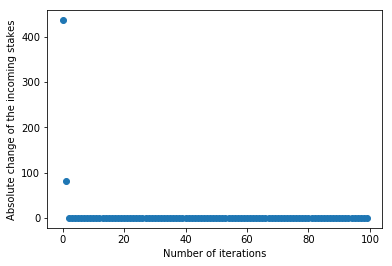

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,sum
0,78.162013,1.074379,0.010440,0.000026,2.358866e-08,1.026712e-10,3.069262e-13,1.011561e-15,3.270442e-18,1.063305e-20,...,2.100000e-27,2.000000e-27,2.100000e-27,2.100000e-27,2.000000e-27,2.100000e-27,2.100000e-27,2.000000e-27,2.100000e-27,79.246857
1,37.993316,2.959712,0.069030,0.000087,1.004187e-07,3.033183e-10,9.489691e-13,3.061203e-15,9.924735e-18,3.222576e-20,...,1.800000e-26,1.800000e-26,0.000000e+00,1.800000e-26,1.800000e-26,0.000000e+00,1.800000e-26,1.800000e-26,0.000000e+00,41.022145
2,32.599731,23.498419,0.241619,0.000160,1.607149e-07,1.141887e-10,5.355979e-13,1.609463e-15,5.315401e-18,1.719785e-20,...,1.110000e-26,1.210000e-26,3.200000e-27,1.110000e-26,1.210000e-26,3.200000e-27,1.110000e-26,1.210000e-26,3.200000e-27,56.339930
3,33.208179,0.733488,0.001822,0.000006,1.152705e-08,3.947524e-11,1.245750e-13,4.050706e-16,1.313773e-18,4.268337e-21,...,6.000000e-28,6.000000e-28,0.000000e+00,6.000000e-28,6.000000e-28,0.000000e+00,6.000000e-28,6.000000e-28,0.000000e+00,33.943494
4,43.734439,1.523148,0.016815,0.000041,2.751194e-08,1.366125e-10,3.962565e-13,1.317290e-15,4.248911e-18,1.382244e-20,...,1.320000e-26,1.540000e-26,2.200000e-27,1.320000e-26,1.540000e-26,2.200000e-27,1.320000e-26,1.540000e-26,2.200000e-27,45.274443
5,43.232489,13.823519,0.013614,0.000053,5.564325e-08,2.154410e-10,6.600539e-13,2.154051e-15,6.979016e-18,2.267398e-20,...,7.000000e-27,5.200000e-27,2.200000e-27,7.000000e-27,5.200000e-27,2.200000e-27,7.000000e-27,5.200000e-27,2.200000e-27,57.069676
6,34.824835,5.035751,0.016313,0.000048,3.276762e-08,1.604508e-10,4.660883e-13,1.548211e-15,4.994441e-18,1.624667e-20,...,5.000000e-27,4.100000e-27,3.100000e-27,5.000000e-27,4.100000e-27,3.100000e-27,5.000000e-27,4.100000e-27,3.100000e-27,39.876947
7,34.171527,7.716683,0.059868,0.000048,2.154913e-07,8.024046e-10,2.691531e-12,8.825056e-15,2.875121e-17,9.348517e-20,...,1.000000e-26,1.000000e-26,0.000000e+00,1.000000e-26,1.000000e-26,0.000000e+00,1.000000e-26,1.000000e-26,0.000000e+00,41.948126
8,59.995604,18.748409,0.088775,0.000167,5.327733e-07,1.694677e-09,5.477525e-12,1.777156e-14,5.771473e-17,1.875006e-19,...,1.000000e-26,1.000000e-26,0.000000e+00,1.000000e-26,1.000000e-26,0.000000e+00,1.000000e-26,1.000000e-26,0.000000e+00,78.832956
9,37.948995,6.322950,0.004037,0.000019,2.750050e-08,1.069359e-10,3.256633e-13,1.069103e-15,3.459069e-18,1.124466e-20,...,4.100000e-27,3.000000e-27,1.100000e-27,4.100000e-27,3.000000e-27,1.100000e-27,4.100000e-27,3.000000e-27,1.100000e-27,44.276001


In [17]:
based_on_importance_iteration = iterating_recalculating_stakes_with_importance(initial_stake, initial_importance)
based_on_importance_iteration

In [18]:
#MODEL3: limited number of nodes 

In [19]:
numNodes=10
def recalculating_stakes_limited_channel(stake, importance):
    #calculating sum of the original stake
    sum_stake = sum([sum(stake[li]) for li in range(numNodes)])
    
    #creating an empy stake matrix with the original shape
    stake_mod = [[0 for i in range(numNodes)] for j in range(numNodes)]
    stake_mod_i = [[0 for i in range(numNodes)] for j in range(numNodes)]
    
    #populating the new matric with recalculation
    for p in range(numNodes):
        for r in range(numNodes):
            if p == r:
                stake_mod[p][r] = 0     
            elif stake[p][r] == 0:
                stake_mod[p][r] = 0
            else:
                stake_mod[p][r] = importance[r]/(sum(importance)-importance[p])*sum(stake[p])
    
    #limiting the number of channels to the original number
    for l in range(numNodes):
        for m in range(numNodes):
            if l == m:
                stake_mod_i[l][m] = 0     
            elif stake[l][m] == 0:
                stake_mod_i[l][m] = 0
            else:
                stake_mod_i[l][m] = stake_mod[l][m]/sum(stake_mod[l])*sum(stake[l])   
    
    return stake_mod_i

In [20]:
based_on_limited_channel = recalculating_stakes_limited_channel(initial_stake, initial_importance)
based_on_limited_channel

[[0,
  Decimal('7.747040563978495063485055825'),
  0,
  0,
  Decimal('4.261161620236184952765106921'),
  0,
  0,
  Decimal('8.991797815785319983749837254'),
  0,
  0],
 [Decimal('8.541694889545983627535682946'),
  0,
  Decimal('5.095335782219295480801045293'),
  0,
  0,
  0,
  0,
  0,
  Decimal('43.06296932823472728654789359'),
  0],
 [Decimal('33.60000000000000142108547152'), 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [Decimal('1.307108177448141662811321035'),
  Decimal('3.282720068057431092797550216'),
  0,
  0,
  0,
  0,
  0,
  Decimal('3.810171754494428043751706480'),
  0,
  0],
 [Decimal('2.708459113323575321001604577'),
  0,
  0,
  0,
  0,
  Decimal('7.278394575882059281855244881'),
  Decimal('3.558445079709959022490944265'),
  0,
  Decimal('13.65470123108440921682314931'),
  0],
 [0,
  0,
  Decimal('2.044557828563666346355005994'),
  0,
  Decimal('4.734620116158882123562712848'),
  0,
  Decimal('4.503069265595741897999297597'),
  Decimal('9.990878218951709032794738798'),
  Decimal('17.2794757

In [21]:
based_on_limited_channel_importance = calcImportance(based_on_limited_channel)

In [22]:
def iterating_recalculating_stakes_limited(stake, importance):
    iterated_stakes = []
    iterated_importance = []
    difference_between_stake_matrix = []
    added_list =[]
    incoming_stake = []
    incoming_stake_sum = []
    
    
    for _ in range(100):
        a = recalculating_stakes_limited_channel(stake, importance)
        iterated_stakes.append(a)
        
        b = calcImportance(a)
        iterated_importance.append(importance)
        
        #the following session calculates the difference between each iteration
        #dataframe of the initial stake matrix
        df_stake = pd.DataFrame(stake)
        
        #dataframe of the recalculated stake
        df_a = pd.DataFrame(a)
        
        #difference between the frames
        c = df_stake - df_a
        difference_between_stake_matrix.append(c)
              
        stake = a 
        importance = b
        
    input_stake_matrix = difference_between_stake_matrix
        
    #calculating the sum of the change
    for k in range(len(input_stake_matrix)):
        #absolute sum of the difference
        sum_of_difference_by_column = (abs(input_stake_matrix[k])).sum()
        total_sum_of_difference = sum(sum_of_difference_by_column)
        
        #craeting a list of the difference
        added_list.append(total_sum_of_difference)
        incoming_stake.append(sum_of_difference_by_column)
        
    #creating dataframe form the list and transpose
    input_incoming_stake = (pd.DataFrame(incoming_stake)).T
    input_incoming_stake["sum"] = input_incoming_stake.sum(axis=1)
    
    #plotting
    df = pd.DataFrame(added_list)
    plt.scatter(df.index,df[0])
    plt.xlabel('Number of iterations')
    plt.ylabel('Absolute change of the incoming stakes')
    plt.show()
        
    return iterated_stakes

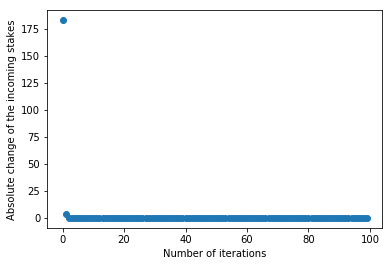

In [23]:
iteration_based_on_limited_channel_recalculation = iterating_recalculating_stakes_limited(initial_stake, initial_importance)